# Import Python and Sklearn Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering

# Reading Data from the dataset

In [2]:
df = pd.read_csv('weatherdata.csv')

# Data Filtering

In [3]:
#filtering data such as using just necessary columns
usefuldata = ['TempAvgF','DewPointAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles', 'WindAvgMPH', 'PrecipitationSumInches']
data = df[usefuldata]

In [4]:
#filtering data such has finding non numeric datas and rows.
def nonnumeric(usefuldata, data):
    r = np.zeros(data.shape[0], dtype=bool)
    for column in usefuldata:
        r = r | pd.to_numeric(data[column], errors='coerce').isnull()
    return r
def dfrowsnonnumeric(dataframe):
    return data[nonnumeric(usefuldata, data)]
emptyrows = dfrowsnonnumeric(data).index.values
#data filtering such as replacing the T value
def numberorzero(value):
    try:
        parsed = float(value)
        return parsed
    except:
        return 0
data['PrecipitationSumInches'] = df['PrecipitationSumInches']
trace = nonnumeric(['PrecipitationSumInches'], data).astype(int)
data = data.assign(PrecipitationTrace=trace.values)
data['PrecipitationSumInches'] = data['PrecipitationSumInches'].apply(numberorzero)
data.iloc[0:10,:]

C:\Users\praya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,60,49,75,29.68,7,4,0.46,0
1,48,36,68,30.13,10,6,0.00,0
2,45,27,52,30.49,10,3,0.00,0
3,46,28,56,30.45,10,4,0.00,0
4,50,40,71,30.33,10,2,0.00,1
5,48,36,63,30.4,9,3,0.00,0
6,53,39,65,30.39,9,1,0.00,1
7,51,39,64,30.17,10,2,0.00,1
8,50,41,76,30.1,10,5,0.00,0
9,40,26,60,30.33,10,5,0.00,0


In [5]:
emptyrows = dfrowsnonnumeric(data).index.values
emptyrows

array([174, 175, 176, 177, 596, 597, 598, 638, 639, 741, 742, 953],
      dtype=int64)

In [6]:
#Data filtering such as events classification
events = df[['Events']].replace(' ', 'None')
differentevents = set()
for value in events.Events.value_counts().index:
    splitted = [x.strip() for x in value.split(',')]
    differentevents.update(splitted)
differentevents
individualevents = pd.DataFrame()
for typeofevent in differentevents:
    allevents = events.Events.str.contains(typeofevent)
    individualevents = pd.concat([individualevents , pd.DataFrame(data={typeofevent: allevents.values})], join='outer', axis=1)

In [7]:
#dropping columns with empty rows.
finaldata = data.drop(emptyrows)
finalevents = individualevents.drop(emptyrows)

In [8]:
#converting the columns to numeric
finaldata = finaldata.apply(pd.to_numeric)
finaldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1318
Data columns (total 8 columns):
TempAvgF                     1307 non-null int64
DewPointAvgF                 1307 non-null int64
HumidityAvgPercent           1307 non-null int64
SeaLevelPressureAvgInches    1307 non-null float64
VisibilityAvgMiles           1307 non-null int64
WindAvgMPH                   1307 non-null int64
PrecipitationSumInches       1307 non-null float64
PrecipitationTrace           1307 non-null int32
dtypes: float64(2), int32(1), int64(5)
memory usage: 86.8 KB


# Preprocessing data

In [9]:
from sklearn import preprocessing
dvalues = finaldata.values
min_max_scaler = preprocessing.MinMaxScaler()
finaldata = pd.DataFrame(min_max_scaler.fit_transform(finaldata), columns=finaldata.columns, index=finaldata.index)

# Training the Model

In [10]:
random_state = 42 #gives out the same output as the first time making the split.
X_train, X_test = train_test_split(finaldata, test_size=0.2, random_state=random_state)
y_train, y_test = train_test_split(finalevents, test_size=0.2, random_state=random_state)
numberofclusters = len(differentevents)

# Agglomerative Clustering

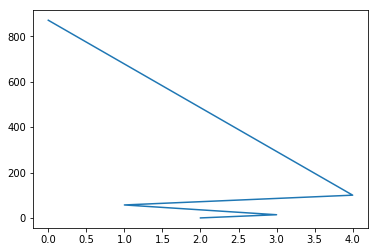

In [11]:
clustering = AgglomerativeClustering(n_clusters=numberofclusters, linkage="average").fit(X_train)
resultac = pd.DataFrame(clustering.labels_)
resultac.iloc[:,0].value_counts().plot.line()

# Multi-Lable Clustering

In [12]:
eventorder = finalevents.sum().sort_values(ascending=False).index
acorder = resultac.iloc[:,0].value_counts().index
clusterdistribution = {}
for i in range(numberofclusters):
    clusterdistribution.update({acorder[i]:eventorder[i]})
clusterdistribution

{0: 'None', 4: 'Rain', 1: 'Thunderstorm', 3: 'Fog', 2: 'Snow'}

# Calculating Clusters Centroids

In [13]:
clustercenter = {}
for key in clusterdistribution:
    cluster_indices = resultac.loc[resultac[0] == key].index
    cluster_data = X_train.iloc[cluster_indices]
    mean = cluster_data.mean(axis=0).values
    clustercenter.update({key:mean})
clustercenter

{0: array([0.66684626, 0.71558485, 0.53737274, 0.39408867, 0.92715517,
        0.36185998, 0.01333112, 0.        ]),
 4: array([0.66259282, 0.7603378 , 0.62192362, 0.39995008, 0.9220297 ,
        0.39423942, 0.        , 1.        ]),
 1: array([0.37553879, 0.59077079, 0.81453202, 0.46479281, 0.47844828,
        0.40125392, 0.06999337, 0.        ]),
 3: array([0.690625  , 0.88431373, 0.85142857, 0.28403361, 0.46666667,
        0.44242424, 0.59641026, 0.        ]),
 2: array([0.015625  , 0.05882353, 0.3       , 0.83193277, 1.        ,
        0.36363636, 0.        , 1.        ])}

In [14]:
def distance_from_centroid_to_datapoints(dataframe):
    clusterdist = np.zeros((dataframe.shape[0], numberofclusters))
    for i in range(dataframe.shape[0]):
        for key in clusterdistribution:
            distance = np.linalg.norm(dataframe.iloc[[i]].values[0]-clustercenter[key])
            clusterdist[i,key] = distance
    column_names = [clusterdistribution[k] for k in clusterdistribution]
    return pd.DataFrame(clusterdist, index=dataframe.index, columns=column_names)
distances = distance_from_centroid_to_datapoints(X_train)
distances.head()

,None,Rain,Thunderstorm,Fog,Snow
1304,1.076076,1.362176,1.393672,1.370068,0.410872
547,0.545300,0.611610,1.757403,0.511271,1.114620
293,0.356203,0.856249,1.684327,0.875558,1.052542
10,0.771528,0.883183,1.128419,1.326534,1.298398
147,0.388148,0.800786,1.494443,0.964510,1.075485


In [15]:
def eventgroup(distances_dataFrame):
    return distances_dataFrame.apply(lambda x: x<x.min()*1.02, axis=1)
classification = eventgroup(distances)
X_train = classification.reindex(sorted(classification.columns), axis=1)
y_train = y_train.reindex(sorted(y_train.columns), axis=1)
def accuracy(X, y):    
    comparison = X == y
    val_counts = comparison.all(axis=1).value_counts()
    percentageCorrect = val_counts.at[True] / X.shape[0] * 100
    return percentageCorrect

In [16]:
accuracy(X_train, y_train)

65.07177033492823

# Weather Forecast Events using Cluster Analysis

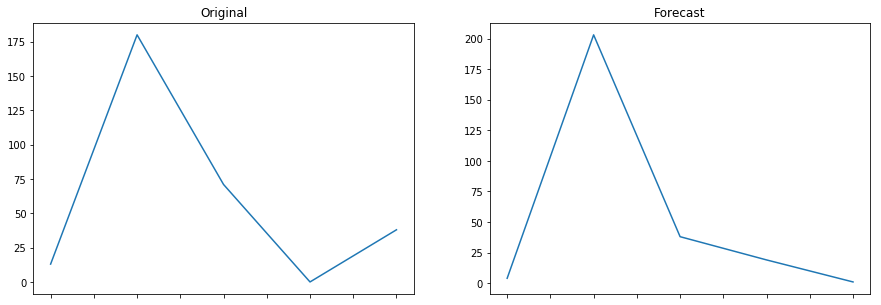

In [17]:
distancesDf = distance_from_centroid_to_datapoints(X_test)
classification = eventgroup(distancesDf)
X_test = classification.reindex(sorted(classification.columns), axis=1)
y_test = y_test.reindex(sorted(y_train.columns), axis=1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_test.sum().plot.line(ax=ax[0], title="Original")
X_test.sum().plot.line(ax=ax[1], title="Forecast")

In [18]:
accuracy(X_test, y_test)

69.46564885496184